In [1]:
!pip install pymorphy3 nltk tqdm catboost wordcloud seaborn fasttext

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-macosx_15_0_universal2.whl size=648773 sha256=99903609d23754beef19d4bc6c23ee6c5f17405ffc74e5483fd826526d5a050c
  Stored in directory: /Users/alposha/Library/Caches/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [fasttext]


In [67]:
from pymorphy3 import MorphAnalyzer
import re
import nltk
from nltk.corpus import stopwords
from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import fasttext

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alposha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Загрузка данных и очистка

In [5]:
# data = pd.read_csv('/content/drive/My Drive/Anime_reviews_RU.csv')
data = pd.read_csv('Anime_reviews_RU.csv')
data.head()

,Unnamed: 0,Anime,Rate,Text
0,0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи..."
1,1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над..."
2,2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х..."
3,3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...
4,4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ..."


Удалим ненужные столбцы

In [6]:
data.drop(data.columns[[0, 1]], axis=1, inplace=True)
data.head()

,Rate,Text
0,Нейтральный,"после первой арки несколько разочаровался, ожи..."
1,Положительный,"Концовка какая-то мутная, ничего не понял. Над..."
2,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х..."
3,Положительный,Только что досмотрел и меня переполняют эмоции...
4,Положительный,"И правда не оторваться. Но, по-моему, то, что ..."


Удалим наны

In [7]:
data[data['Text'].isna()]

,Rate,Text
19745,Отрицательный,NaN


In [8]:
data = data.dropna(subset=['Text'])

In [9]:
data[data['Text'].isna()]

,Rate,Text


Проверим на дубликаты

In [10]:
data['Text'].duplicated().sum()

np.int64(50)

In [11]:
data.drop_duplicates(subset=['Text'], inplace=True)

In [13]:
data.duplicated().sum()

np.int64(0)

# Предобработка данных

In [14]:
# Инициализация MorphAnalyzer
morph = MorphAnalyzer()

# Загрузка стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

def preprocess_text(text):
    # Приводим текст к нижнему регистру
    text = text.lower()

    # Убираем цифры и ненужные символы с помощью регулярных выражений
    text = re.sub(r'[^а-яё\s]', ' ', text)

    # Лемматизация с использованием pymorphy3 и удаление стоп-слов
    lemmatized_text = []
    for word in text.split():
        # Лемматизация каждого слова
        lemma = morph.parse(word)[0].normal_form
        # Добавляем лемму в список, если слово не является стоп-словом
        if lemma not in stop_words:
            lemmatized_text.append(lemma)

    # Возвращаем очищенный и лемматизированный текст
    return ' '.join(lemmatized_text)

if 'Text' in data.columns:
    tqdm.pandas()
    data['cleaned_review'] = data['Text'].progress_apply(preprocess_text)
    print('Предобработка текста завершена.')
    display(data.head())

100%|██████████| 73165/73165 [13:44<00:00, 88.71it/s] 

Предобработка текста завершена.


,Rate,Text,cleaned_review
0,Нейтральный,"после первой арки несколько разочаровался, ожи...",первый арка несколько разочароваться ожидать б...
1,Положительный,"Концовка какая-то мутная, ничего не понял. Над...",концовка мутный понять надеяться второй сезон ...
2,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х...",сказать никакой сравненить пытаться подражать ...
3,Положительный,Только что досмотрел и меня переполняют эмоции...,досмотреть переполнять эмоция шедевр затягиват...
4,Положительный,"И правда не оторваться. Но, по-моему, то, что ...",правда оторваться медуза серия езмъ плюс иначе...


In [16]:
data.to_csv('cleaned_data.csv', index=False, encoding='utf-8-sig')

# EDA

In [17]:
rate_by_count = data['Rate'].value_counts().reset_index()
rate_by_count

,Rate,count
0,Положительный,30045
1,Нейтральный,25243
2,Отрицательный,17877


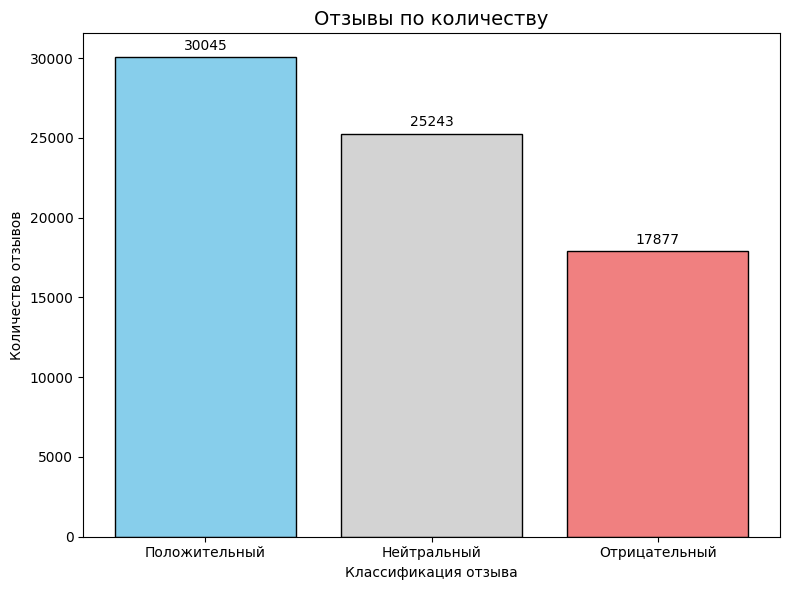

In [18]:
plt.figure(figsize=(8, 6))
bars = plt.bar(rate_by_count['Rate'],
               rate_by_count['count'],
               edgecolor='black',
               color=['skyblue', 'lightgray', 'lightcoral']
)
plt.xlabel('Классификация отзыва')
plt.ylabel('Количество отзывов')
plt.title('Отзывы по количеству', fontsize=14)
plt.xticks(ticks=[0, 1, 2],
           labels=['Положительный', 'Нейтральный', 'Отрицательный']
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval + 300,
             yval,
             ha='center',
             va='bottom'
)

plt.tight_layout()
plt.show()

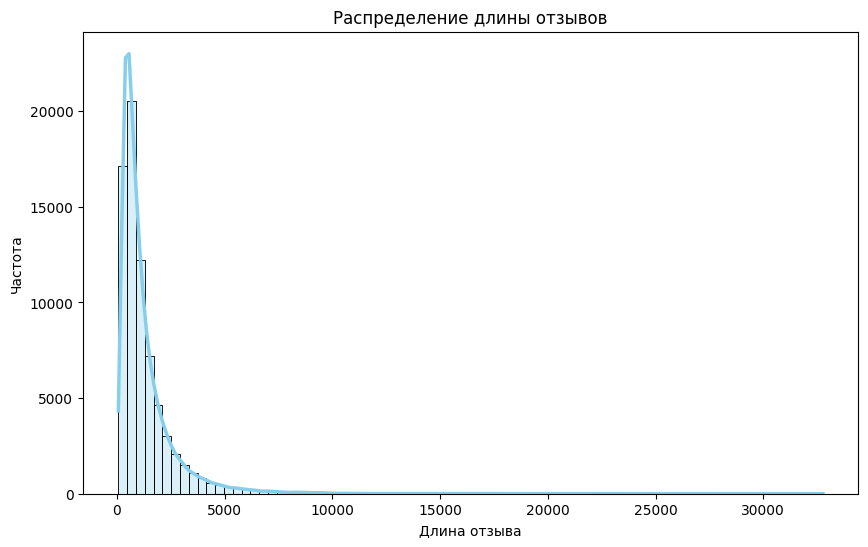

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Text'].apply(len),
             bins=80,
             kde=True,
             color='skyblue',
             alpha=0.3,
             line_kws={'linewidth': 2.5, 'alpha': 1}
)

plt.xlabel('Длина отзыва')
plt.ylabel('Частота')
plt.title('Распределение длины отзывов')
plt.show()


Просмотрим облако слов и топ 20 слов по каждому классу

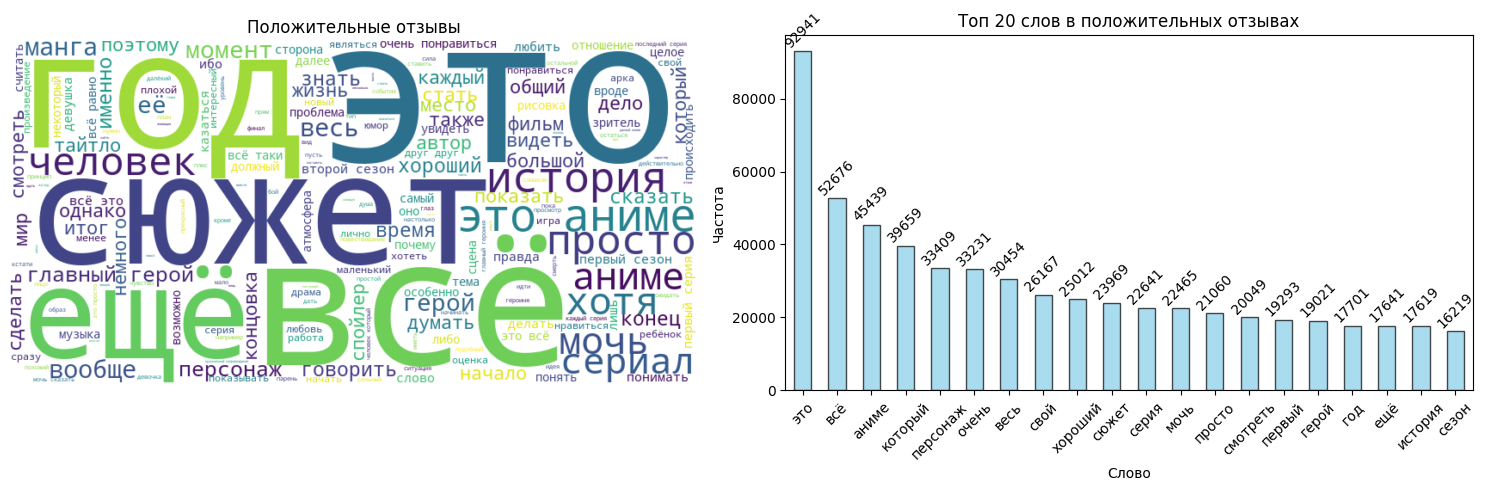

In [21]:
text_positive = ' '.join(data.loc[data['Rate'] == 'Положительный', 'cleaned_review'])
wordcloud_positive = WordCloud(width=800,
                               height=400,
                               background_color='white'
                               ).generate(text_positive)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Положительные отзывы')

positive_words = text_positive.split()
positive_word_counts = pd.Series(positive_words).value_counts().head(20)

plt.subplot(1, 2, 2)
bars = positive_word_counts.plot(kind='bar',
                                 color='skyblue',
                                 edgecolor = 'black',
                                 alpha=0.7)
plt.title('Топ 20 слов в положительных отзывах')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.xticks(rotation=45)
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval+200,
             yval,
             ha='center',
             va='bottom',
             rotation=45
)

plt.tight_layout()
plt.show()


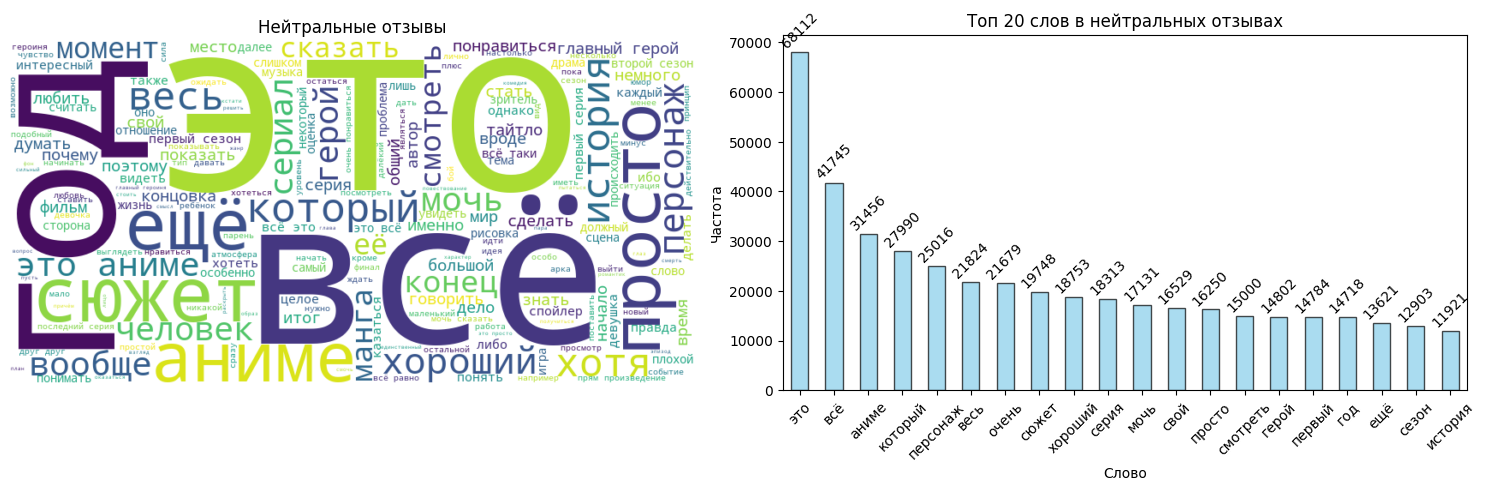

In [22]:
text_neutral = ' '.join(data.loc[data['Rate'] == 'Нейтральный', 'cleaned_review'])
wordcloud_neutral = WordCloud(width=800,
                               height=400,
                               background_color='white'
                               ).generate(text_neutral)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Нейтральные отзывы')

neutral_words = text_neutral.split()
neutral_word_counts = pd.Series(neutral_words).value_counts().head(20)

plt.subplot(1, 2, 2)
bars = neutral_word_counts.plot(kind='bar',
                                color='skyblue',
                                edgecolor = 'black',
                                alpha=0.7)
plt.title('Топ 20 слов в нейтральных отзывах')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.xticks(rotation=45)
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval+200,
             yval,
             ha='center',
             va='bottom',
             rotation=45
)

plt.tight_layout()
plt.show()



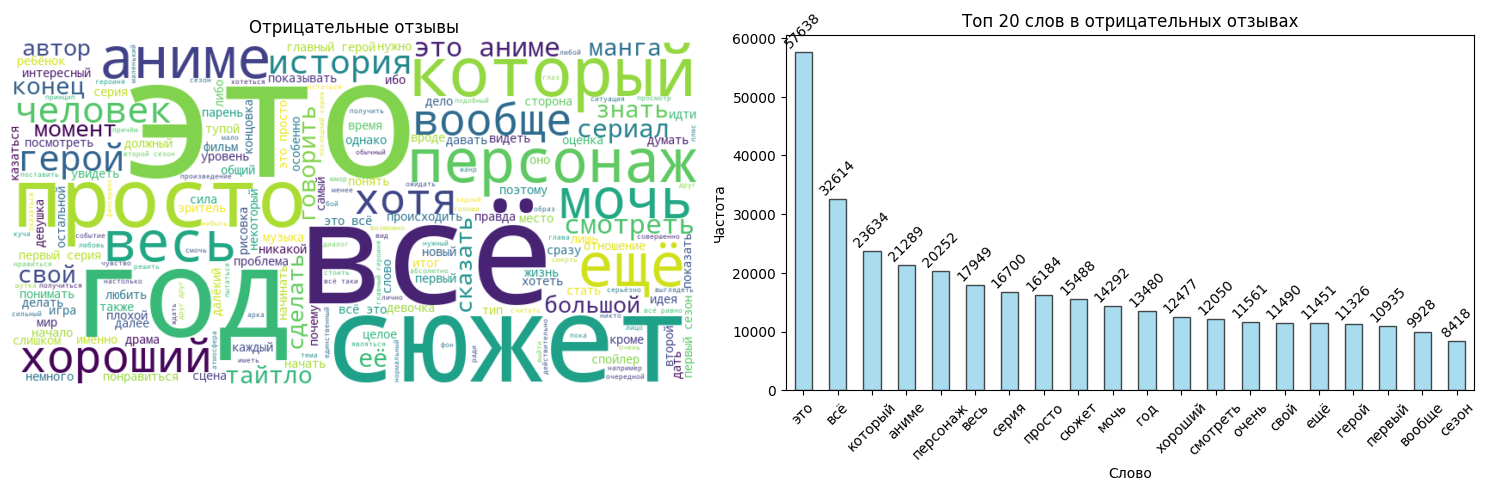

In [23]:
text_negative = ' '.join(data.loc[data['Rate'] == 'Отрицательный', 'cleaned_review'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(text_negative)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Отрицательные отзывы')

negative_words = text_negative.split()
negative_word_counts = pd.Series(negative_words).value_counts().head(20)

plt.subplot(1, 2, 2)
bars = negative_word_counts.plot(kind='bar', color='skyblue', edgecolor = 'black', alpha=0.7)
plt.title('Топ 20 слов в отрицательных отзывах')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.xticks(rotation=45)
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval+200,
             yval,
             ha='center',
             va='bottom',
             rotation=45
)

plt.tight_layout()
plt.show()


# Разделение на тестовую и обвучающую выбрки, векторизация

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_review'],
    data['Rate'],
    test_size=0.2,
    random_state=228
)

print(X_train.shape, X_test.shape)

(58532,) (14633,)


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(X_train_tfidf.shape, X_test_tfidf.shape)

(58532, 20000) (14633, 20000)


Добавим функцию для удобства вывода метрик

In [49]:
def print_metrics(model, y_test, y_pred):
  print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
  print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.4f}")
  print(f"F1-score:  {f1_score(y_test, y_pred, average='weighted'):.4f}")
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  class_labels = model.classes_
  plt.figure(figsize=(6, 5))
  sns.heatmap(
      cm,
      annot=True,
      fmt='d',
      cmap='Blues',
      cbar=True,
      xticklabels=class_labels,  # подписи по оси X
      yticklabels=class_labels   # подписи по оси Y
)
  plt.title("Матрица ошибок")
  plt.xlabel("Предсказанный класс")
  plt.ylabel("Реальный класс")
  plt.tight_layout()
  plt.show()

# Случайны лес

Accuracy:  0.5410
Precision: 0.5511
Recall:    0.5410
F1-score:  0.5147
               precision    recall  f1-score   support

  Нейтральный       0.46      0.30      0.36      5085
Отрицательный       0.71      0.38      0.50      3545
Положительный       0.54      0.84      0.65      6003

     accuracy                           0.54     14633
    macro avg       0.57      0.51      0.50     14633
 weighted avg       0.55      0.54      0.51     14633



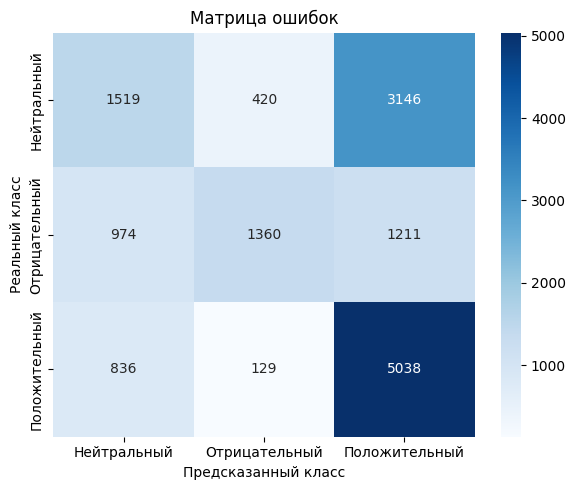

In [83]:
model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=200, 
    min_samples_leaf=3,
    random_state=228,
)
model_rf.fit(X_train_tfidf, y_train)

y_pred = model_rf.predict(X_test_tfidf)
print_metrics(model_rf, y_test, y_pred)

# Логистическая регрессия

Accuracy:  0.5831
Precision: 0.5785
Recall:    0.5831
F1-score:  0.5791
               precision    recall  f1-score   support

  Нейтральный       0.47      0.43      0.45      5085
Отрицательный       0.65      0.60      0.63      3545
Положительный       0.62      0.70      0.66      6003

     accuracy                           0.58     14633
    macro avg       0.58      0.58      0.58     14633
 weighted avg       0.58      0.58      0.58     14633



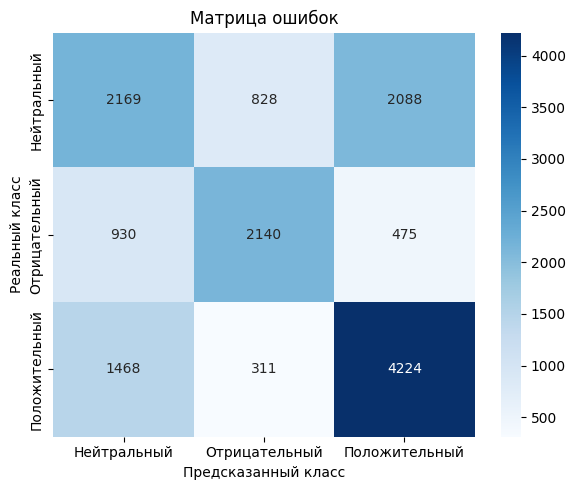

In [52]:
model_lr = LogisticRegression(max_iter=1500)
model_lr.fit(X_train_tfidf, y_train)

y_pred = model_lr.predict(X_test_tfidf)

print_metrics(model_lr, y_test, y_pred)

# CatBoost

0:	learn: 1.0944027	total: 2.6s	remaining: 12m 56s
50:	learn: 1.0074824	total: 2m 16s	remaining: 11m 6s
100:	learn: 0.9761021	total: 4m 23s	remaining: 8m 39s
150:	learn: 0.9562660	total: 6m 33s	remaining: 6m 28s
200:	learn: 0.9406492	total: 8m 47s	remaining: 4m 19s
250:	learn: 0.9263835	total: 11m 8s	remaining: 2m 10s
299:	learn: 0.9142165	total: 13m 26s	remaining: 0us
Accuracy:  0.5535
Precision: 0.5486
Recall:    0.5535
F1-score:  0.5390
               precision    recall  f1-score   support

  Нейтральный       0.46      0.35      0.40      5085
Отрицательный       0.63      0.47      0.54      3545
Положительный       0.57      0.77      0.66      6003

     accuracy                           0.55     14633
    macro avg       0.56      0.53      0.53     14633
 weighted avg       0.55      0.55      0.54     14633



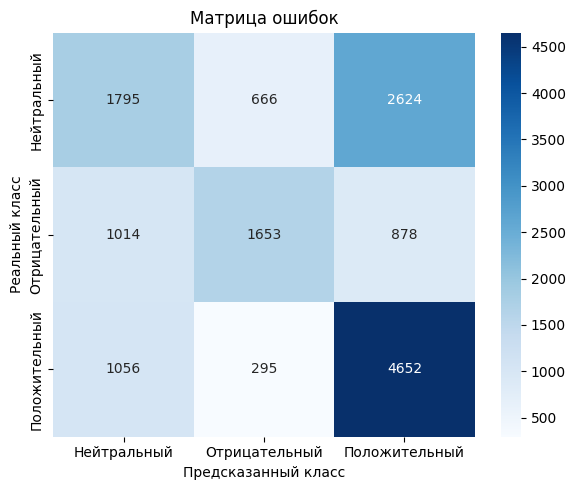

In [56]:
model_cb = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    verbose=50
)

model_cb.fit(X_train_tfidf, y_train)

y_pred = model_cb.predict(X_test_tfidf)

print_metrics(model_cb, y_test, y_pred)

# Замена tf-idf на fasttext

In [84]:
data['formatted'] = '__label__' + data['Rate'] + ' ' + data['Text']

# Сохраняем в файл для обучения
data[['formatted']].to_csv('train_data.txt', index=False, header=False, sep='\t')

# Обучаем модель fastText
model = fasttext.train_supervised(input="train_data.txt", epoch=25, lr=0.1, wordNgrams=2, bucket=100000)

# Сохранение модели
model.save_model("fasttext_model.bin")

Read 14M words
Number of words:  1096988
Number of labels: 3
Progress: 100.0% words/sec/thread: 3381932 lr:  0.000000 avg.loss:  0.309290 ETA:   0h 0m 0s


In [85]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Загрузка обученной модели fastText
model_ft = fasttext.load_model('fasttext_model.bin')  # Загружаем модель fastText

# Функция для получения вектора для текста
def get_fasttext_vector(text, model):
    # Убираем символы новой строки, если они есть
    text = text.replace("\n", " ")
    return model.get_sentence_vector(text)

# Пример данных
X_train = data['Text']
y_train = data['Rate']

# Преобразуем все тексты в вектора с помощью fastText
X_train_fasttext = np.array([get_fasttext_vector(text, model_ft) for text in X_train])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_train_fasttext,
    y_train,
    test_size=0.2,
    random_state=42)

# RandomForest с fasttext

Accuracy:  0.8246
Precision: 0.8240
Recall:    0.8246
F1-score:  0.8236
               precision    recall  f1-score   support

  Нейтральный       0.81      0.75      0.78      5118
Отрицательный       0.81      0.82      0.82      3498
Положительный       0.84      0.89      0.86      6017

     accuracy                           0.82     14633
    macro avg       0.82      0.82      0.82     14633
 weighted avg       0.82      0.82      0.82     14633



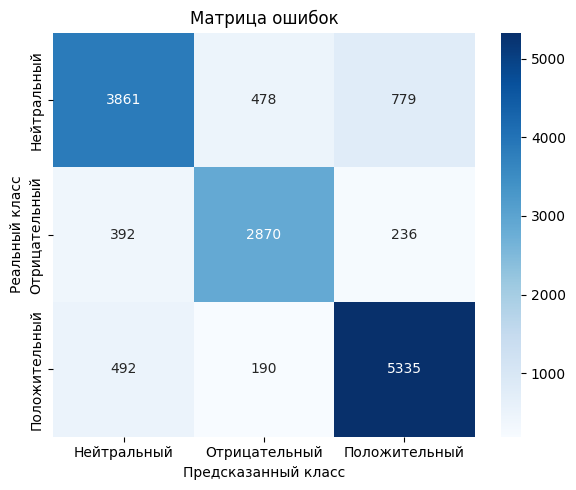

In [86]:
model_rf_ft = RandomForestClassifier(
    n_estimators=200,
    max_depth=200, 
    min_samples_leaf=3,
    random_state=228,
)
model_rf_ft.fit(X_train, y_train)

y_pred = model_rf_ft.predict(X_test)
print_metrics(model_rf_ft, y_test, y_pred)

# LogisticRegression с fasttext

Accuracy:  0.8252
Precision: 0.8247
Recall:    0.8252
F1-score:  0.8245
               precision    recall  f1-score   support

  Нейтральный       0.80      0.77      0.79      5118
Отрицательный       0.84      0.80      0.82      3498
Положительный       0.84      0.88      0.86      6017

     accuracy                           0.83     14633
    macro avg       0.82      0.82      0.82     14633
 weighted avg       0.82      0.83      0.82     14633



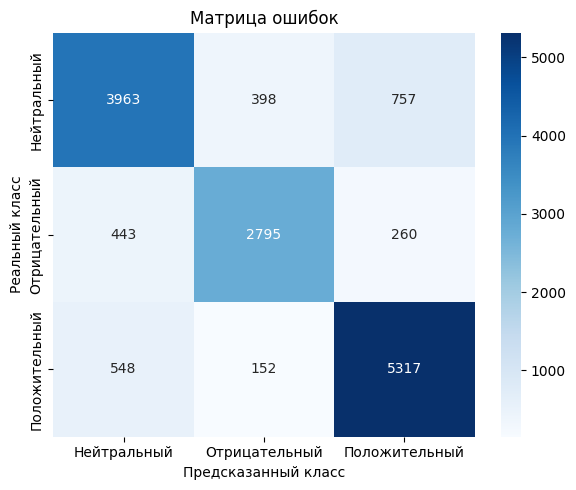

In [63]:
model_lr_ft = LogisticRegression(max_iter=1500)
model_lr_ft.fit(X_train, y_train)

y_pred = model_lr_ft.predict(X_test)

print_metrics(model_lr_ft, y_test, y_pred)

# CatBoost с fastext

0:	learn: 1.0383619	total: 38.9ms	remaining: 11.6s
50:	learn: 0.4517387	total: 993ms	remaining: 4.85s
100:	learn: 0.4296657	total: 1.91s	remaining: 3.76s
150:	learn: 0.4252053	total: 2.83s	remaining: 2.79s
200:	learn: 0.4218862	total: 3.75s	remaining: 1.85s
250:	learn: 0.4183830	total: 4.67s	remaining: 911ms
299:	learn: 0.4147359	total: 5.58s	remaining: 0us
Accuracy:  0.8257
Precision: 0.8254
Recall:    0.8257
F1-score:  0.8246
               precision    recall  f1-score   support

  Нейтральный       0.82      0.75      0.78      5118
Отрицательный       0.81      0.83      0.82      3498
Положительный       0.84      0.89      0.86      6017

     accuracy                           0.83     14633
    macro avg       0.82      0.82      0.82     14633
 weighted avg       0.83      0.83      0.82     14633



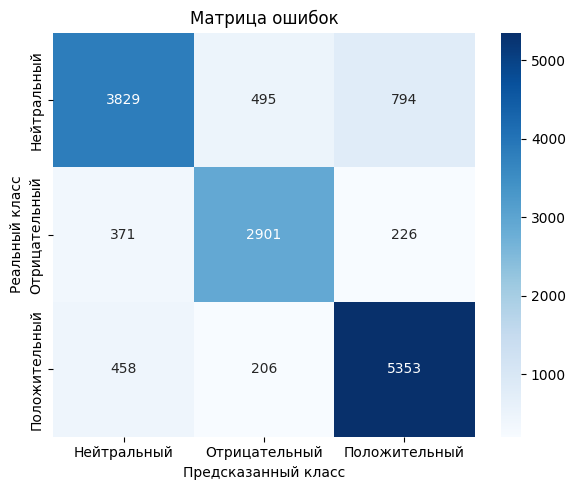

In [90]:
model_cb_ft = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    verbose=50
)

model_cb_ft.fit(X_train, y_train)

y_pred = model_cb_ft.predict(X_test)

print_metrics(model_cb_ft, y_test, y_pred)